In [ ]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [5]:
import shutil
import json
import os

directory_path = f'datasets/test1'
os.makedirs(f'{directory_path}/train/images', exist_ok=True)
os.makedirs(f'{directory_path}/train/labels', exist_ok=True)
os.makedirs(f'{directory_path}/val/images', exist_ok=True)
os.makedirs(f'{directory_path}/val/labels', exist_ok=True)
os.makedirs(f'{directory_path}/keys', exist_ok=True)

def train_test_split(train_size, test_size):
    for i in range(train_size):
        img_name = f'image_{i}.jpg'
        key_name = f'image_{i}.json'
        shutil.copy(f'../TrainingData/TrainingInputs/{img_name}', f'datasets/test1/train/images/')
        shutil.copy(f'../TrainingData/TrainingKeys/{key_name}', f'datasets/test1/keys/')

    for i in range(train_size, train_size+test_size+1):
        img_name = f'image_{i}.jpg'
        key_name = f'image_{i}.json'
        shutil.copy(f'../TrainingData/TrainingInputs/{img_name}', f'datasets/test1/val/images/')
        shutil.copy(f'../TrainingData/TrainingKeys/{key_name}', f'datasets/test1/keys/')

    for i in range(train_size):
        with open(f'datasets/test1/keys/image_{i}.json', "r") as json_file:
            json_data = json.load(json_file)

        with open(f'datasets/test1/train/labels/image_{i}.txt', "w") as file:
            x = int(json_data["position"]["x"])
            y = int(json_data['position']['y'])
            w = int(json_data["position"]["z"])
            h = int(json_data["position"]["w"])

            file.write(f'0 {x/1280} {y/720} {w/1280} {h/720}')

    for i in range(train_size, train_size+test_size+1):
        with open(f"datasets/test1/keys/image_{i}.json", "r") as json_file:
            json_data = json.load(json_file)

        with open(f"datasets/test1/val/labels/image_{i}.txt", "w") as file:
            x = int(json_data["position"]["x"])
            y = int(json_data['position']['y'])
            w = int(json_data["position"]["z"])
            h = int(json_data["position"]["w"])

            file.write(f'0 {x/1280} {y/720} {w/1280} {h/720}')

# input size of training set and validation set, testing set not included yet
train_test_split(200, 50)

In [6]:
from PIL import Image
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Not actually annotating the images, just displaying the bounding boxes generated from unity
def annotate(img):
    image = Image.open(f'datasets/test1/train/images/{img}.jpg')
    with open(f'datasets/test1/keys/{img}.json', "r") as json_file:
        json_data = json.load(json_file)

    x = int(json_data["position"]["x"])
    y = int(json_data['position']['y'])
    w = int(json_data["position"]["z"])
    h = int(json_data["position"]["w"])

    x1 = x + w
    x2 = x - w
    y1 = y + h
    y2 = y - h

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    rect = patches.Rectangle((x2, y2), x1 - x2, y1 - y2, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    circle = patches.Circle((x, y), radius=5, color='b')
    ax.add_patch(circle)

    plt.axis('off')
    plt.show()


In [7]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO('yolov8n.pt')

# Shows results of yolo model prediction
def predict(model, img):
    results = model(f'datasets/test1/train/images/image_{img}.jpg')
    for r in results:
        im_array = r.plot()
        im = Image.fromarray(im_array[..., ::-1])
        plt.figure(figsize=(10, 10))
        plt.imshow(im)
        plt.axis('off')
        plt.show()

100%|██████████| 6.23M/6.23M [00:02<00:00, 3.08MB/s]


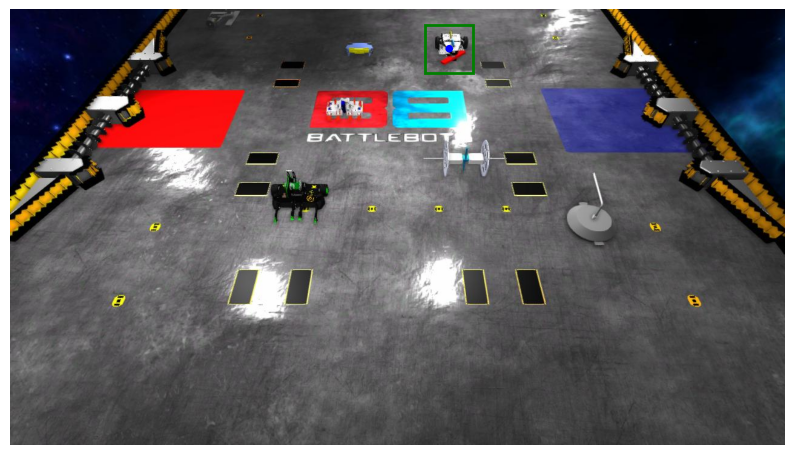

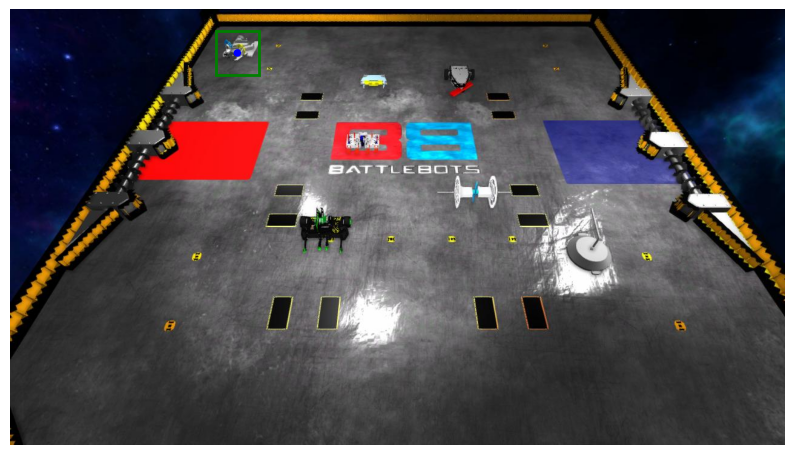

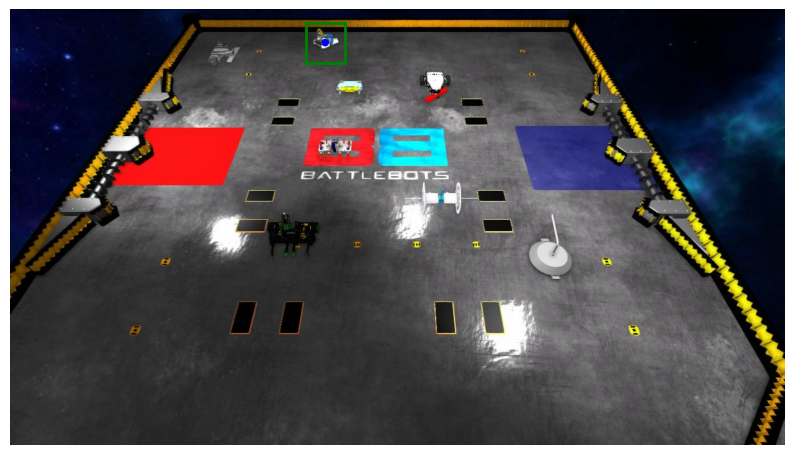


image 1/1 /Users/tongzhang/Documents/school-files/clubs/battlebots/BattleBotsSim/RobotController/MachineLearning/datasets/test1/train/images/image_47.jpg: 384x640 1 person, 1 car, 1 truck, 1 boat, 63.8ms
Speed: 1.6ms preprocess, 63.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


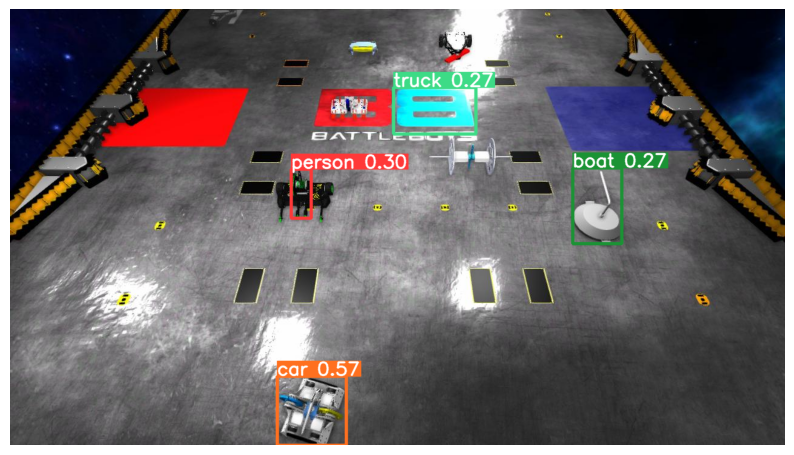


image 1/1 /Users/tongzhang/Documents/school-files/clubs/battlebots/BattleBotsSim/RobotController/MachineLearning/datasets/test1/train/images/image_36.jpg: 384x640 1 person, 1 truck, 61.6ms
Speed: 1.8ms preprocess, 61.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


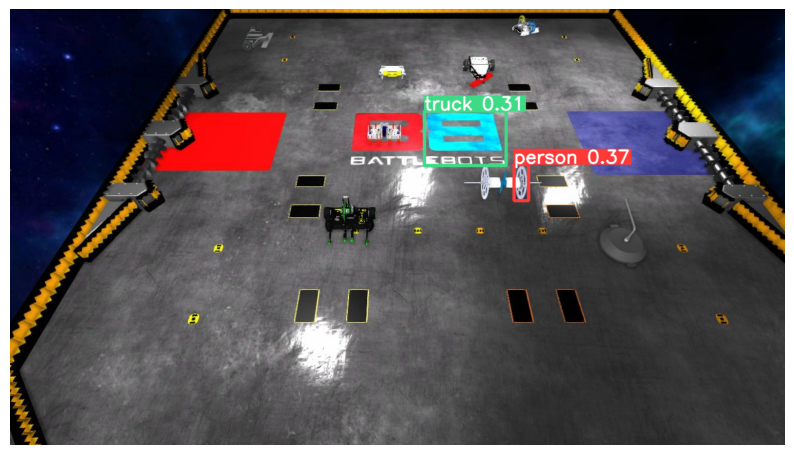


image 1/1 /Users/tongzhang/Documents/school-files/clubs/battlebots/BattleBotsSim/RobotController/MachineLearning/datasets/test1/train/images/image_100.jpg: 384x640 1 person, 58.8ms
Speed: 1.7ms preprocess, 58.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


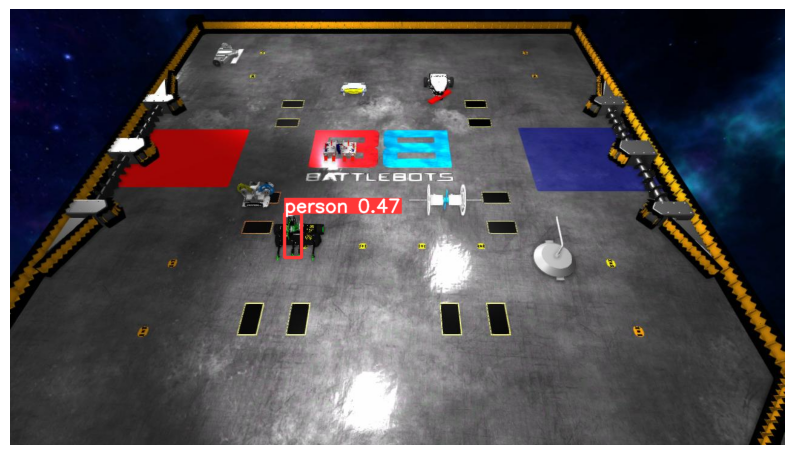

In [10]:
import numpy as np

# Picks random images to show the boudning boxes from unity (not ideal)
for i in np.random.randint(0, 200, 3):
    img_name = f'image_{i}'
    annotate(img_name)

# Picks random training images to show default yolo model's predictions
for i in np.random.randint(1, 200, 3):
    predict(model, i)
